<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch03_CH01_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DST(Dialog State Tracking)
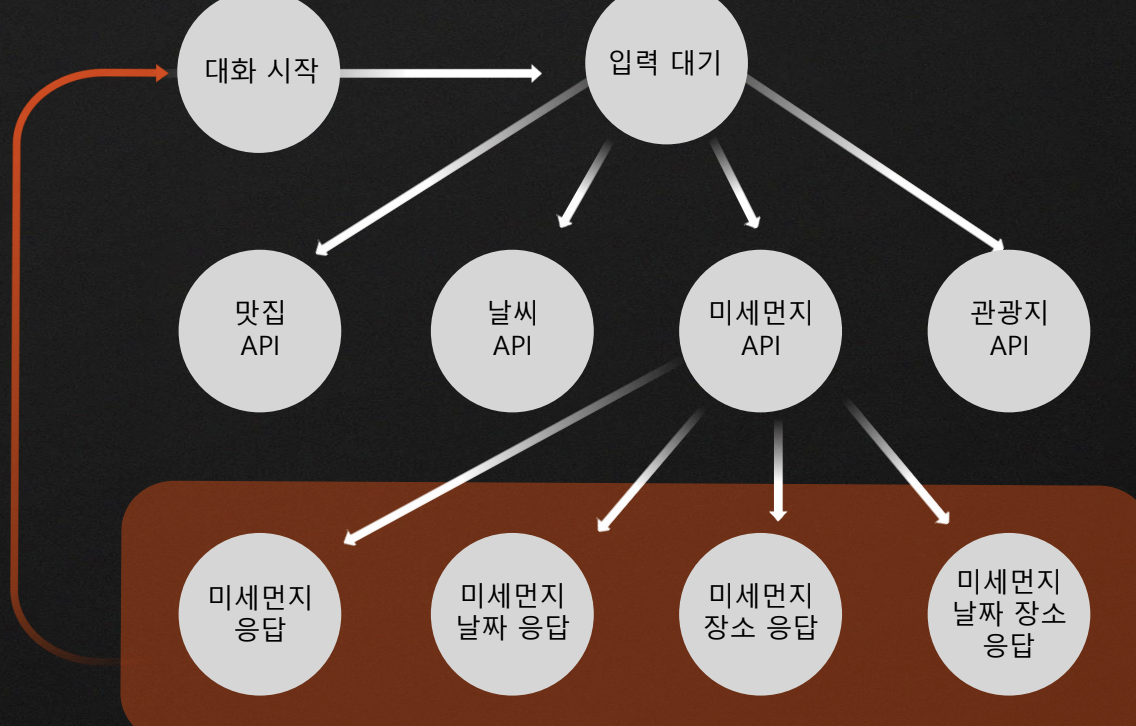

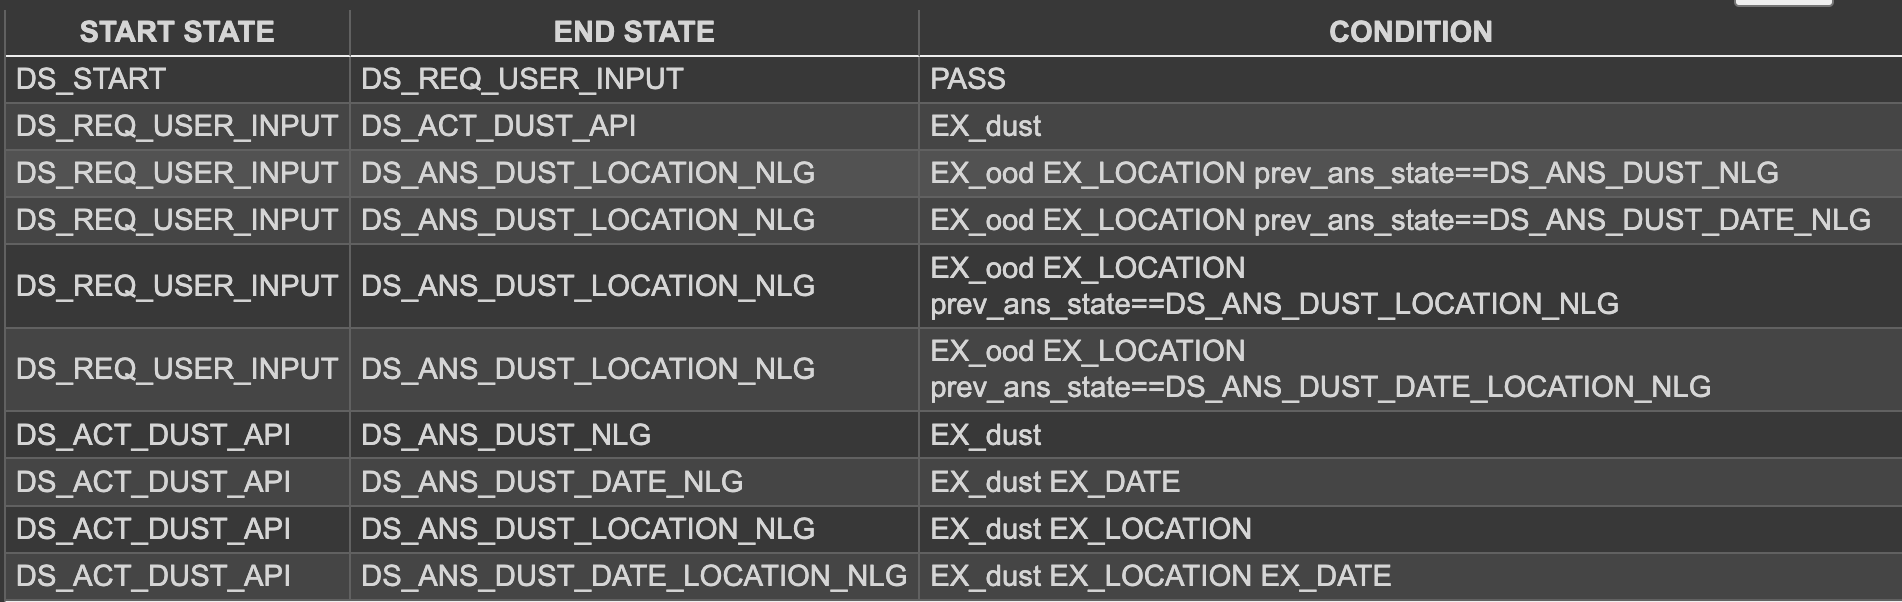

# DM 시스템 구성
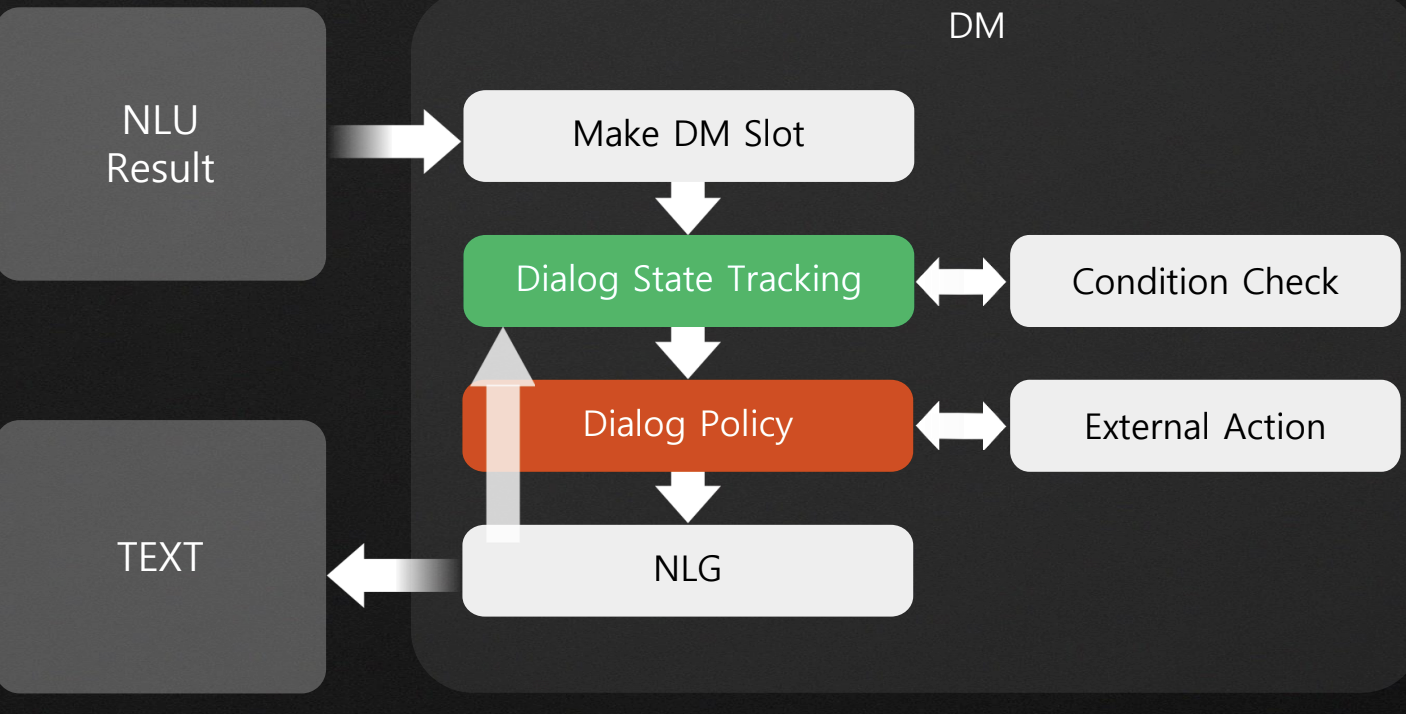

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentencepiece
!pip uninstall pytorch-crf
!pip install pytorch-crf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00


In [3]:
import os
import sys
import json
import random
import pandas as pd
import numpy as np
from collections import deque

%cd /content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
from src.model import BiLSTM_CRF, MakeEmbed, textCNN, DAN, EpochLogger, save
from src.dataset import Preprocessing, MakeDataset
from src.NLU import NaturalLanguageUnderstanding
%cd /root

/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇
/root


In [4]:
class StateConditionCheck: # STATE CONDITION CHECK를 위한 CLASS
    def __init__(self, s_state, e_state, cond):
        self.s_state = s_state
        self.e_state = e_state
        self.conds = cond
        self.parse_cond()
    def print_all(self):
        print("s:{0}, e:{1}, cond:{2}".format(self.s_state,self.e_state,self.conds))
    def parse_cond(self):
        self.conds = self.conds.split()
    def print_end_state(self):
        return self.e_state
    def cond_check(self, nlu_slot):
        conds_check = True
        cond_score = 0
        for cond in self.conds:
            if("==" in cond):
                cond = cond.split("==")
                if(len(cond) == 2):
                    right = cond[0]
                    left  = cond[1]
                    if(right == "prev_ans_state"):
                        if(left in nlu_slot):
                            conds_check = conds_check and True
                            cond_score += 1
                        else:
                            return False , 0
                else:
                    return False , 0
            else:
                cond = cond.split("_")
                if(len(cond) == 1):
                    if(cond[0] == "PASS"):
                        return True, 1
                if(len(cond) == 2):
                    operator = cond[0]
                    value = cond[1]
                    if(operator == "EX"):
                        if(value in nlu_slot):
                            conds_check = conds_check and True
                            cond_score += 1
                        else:
                            return False , 0
        return conds_check,cond_score



In [6]:
class DialogManager:

    def __init__(self):
        self.template_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/template_dataset.csv"
        self.plan_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/plan.csv"

        self.graph = self.load_plan()
        self.state_transition = []
        self.start_state = "DS_START"
        self.dm_result = { # 결과
            "STATE": "",
            "SLOT" : "",
            "NLU"  : {},
            "NLG"  : []
        }
        self.prev_ans_state = "DS_START"
        self.nlg = NLG()
    def __dm_result_init__(self):
        self.dm_result = {
            "STATE": "",
            "SLOT" : "",
            "NLU"  : {},
            "NLG"  : []
        }
    def load_plan(self): # PLAN 로드
        graph = {}
        plan = pd.read_csv(self.plan_dir)
        for rows in plan.iterrows():
            s_state = rows[1]["START STATE"]
            e_state = rows[1]["END STATE"]
            cond = rows[1]["CONDITION"]
            if(graph.get(s_state)):
                graph[s_state].append(StateConditionCheck(s_state,e_state,cond))
            else:
                graph[s_state] = [StateConditionCheck(s_state,e_state,cond)]
        return graph

    def tracking(self, start, visited, dm_slot): # STATE 추적(BFS)
        queue = deque([start])
        visited.append(start)
        score = {}
        count = 0
        print(dm_slot)
        while queue:
            req_flag = False
            cur = queue.popleft()
            if(self.graph.get(cur)):
                for state in self.graph[cur]:
                    cond_check, cond_score = state.cond_check(dm_slot) # 현재 STATE가 DM_SLOT과 CONDITION 매칭이 되는지 확인
                    if cond_check:
                        state_name = state.print_end_state()
                        score[state_name] = cond_score # N개의 STATE가 매칭될수 있으므로 SCORE를 저장하여 추후에 RANKING
                print(score)
                max_cnt = 0
                state_name = "DS_END"
                for name in score: # DST 결과에서 N개의 STATE가 잡힌경우 가장 많은 SLOT과 매칭된(SCORE가 큰) STATE를 최종 선택한다.
                    cnt = score[name]
                    if(max_cnt<=cnt):
                        max_cnt = cnt
                        state_name = name
                '''
                #api 실행 함수 run 및 데이터 저장
                실제로 API 수행 및 수행결과가 필요하다면 이 단계에서 수행후 QUEUE에 저장
                '''
                queue.append(state_name)
                visited.append(state_name)
                if("REQ_" in state_name): # 시스템 질문 턴인 경우 DST 종료
                    req_flag = True
                    break

            if(req_flag):
                break
            count+=1
            if(count == 10): # 무한 루프 방지를 위한 방어 코드
                break

    def make_dm_slot(self, nlu_slot): # NLU SLOT 및 이전 대화 정보등을 DM SLOT이라는 이름으로 저장
        dm_slot = []
        dm_slot.append(nlu_slot["INTENT"])
        for slot in nlu_slot["SLOT"]:
            dm_slot.append(slot.split("^")[0]) #DATE^오늘
        dm_slot.append(self.prev_ans_state)
        return dm_slot

    def dst(self, nlu_slot):
        print("#####대화 상태 추적 시작######")
        self.__dm_result_init__()
        dm_slot = self.make_dm_slot(nlu_slot)

        # 사용자 발화 턴 상태 추적
        self.tracking(self.start_state, self.state_transition, dm_slot)
        print("state_transition")
        print(self.state_transition)
        self.start_state = self.state_transition[-1]
        if(self.start_state == "DS_END"): # END로 끝난 경우 다시 질문하기 위해 DS_START로 STATE변경
            self.start_state = "DS_START"

        if("ANS_" in self.start_state): # 시스템 응답 및 다음 발화 대기를 위한 DST
            self.prev_ans_state = self.start_state
            self.dm_result["STATE"] = self.start_state
            self.dm_result["SLOT"]  = nlu_slot["SLOT"]
            self.dm_result["NLU"]   = nlu_slot
            response = self.nlg.run(self.dm_result) # 시스템 응답 생성
            self.dm_result["NLG"].append(response)

            self.start_state = "DS_START" # 시스템 응답 후 다음 발화 대기를 위한 DST
            self.tracking(self.start_state, self.state_transition, dm_slot)
            self.start_state = self.state_transition[-1]
            self.dm_result["STATE"] = self.start_state

        elif("REQ_" in self.start_state): # 시스템 질문 턴
            self.dm_result["STATE"] = self.start_state
            self.dm_result["SLOT"]  = nlu_slot["SLOT"]
            self.dm_result["NLU"]   = nlu_slot
            response = self.nlg.run(self.dm_result)
            self.dm_result["NLG"].append(response)
        else:
            self.start_state = "DS_REQ_USER_INPUT"
            self.dm_result["STATE"] = self.start_state
            self.dm_result["SLOT"]  = nlu_slot["SLOT"]
            self.dm_result["NLU"]   = nlu_slot
            response = self.nlg.run(self.dm_result)
            self.dm_result["NLG"].append(response)

        print("#####대화 상태 추적 종료######")
        return self.dm_result

    def run(self, nlu_slot):
        print(self.start_state)
        dm_result = self.dst(nlu_slot)
        return dm_result

    def clear(self):
        self.state_transition = []
        self.start_state = "DS_START"
        self.prev_ans_state = "DS_START"


In [7]:
class NLG:

    def __init__(self):
        self.template_dir = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/template_dataset.csv"
        self.values = {
                    "DATE" : "",
                    "LOCATION" : "",
                    "PLACE" : "",
                    "RESTAURANT" : ""
                 }

        self.template = self.load_template()

    def load_template(self):
        template = pd.read_csv(self.template_dir).fillna("")
        return template

    def search_template(self, dm_result):
        state, slots = self.make_search_key(dm_result)
        matched_template = []
        print("")
        print("#######템플릿 검색 시작#######")
        for data in self.template.iterrows():
            state_flag = False
            slot_flag = False

            row = data[1]
            if(row["state"] == state):
                state_flag = True
            if(isinstance(row.get("slot"), str)):
                if(row["slot"] == ""):
                    slot_flag = True
                else:
                    template_slots = sorted(row["slot"].split("^"))
                    key_slots = sorted(slots.split("^"))
                    if(template_slots == key_slots):
                        slot_flag = True
            elif(slots == ""):
                slot_flag = True

            if(state_flag and slot_flag):
                print("#############매칭#############")
                matched_template.append(row["template"])
        print("#######템플릿 검색 종료#######")
        print("")
        return matched_template

    def make_search_key(self, dm_result):
        state = dm_result.get("STATE")

        keys = set()
        for name_value in dm_result.get("SLOT"):
            slot_name = name_value.split("^")[0]
            slot_value = name_value.split("^")[1]
            keys.add(slot_name)
            self.values[slot_name] = slot_value

        slots = "^".join(keys)

        return state, slots

    def replace_slot(self, flag, key, template):
        value = self.values.get(key)
        key = "{"+key+"}"
        if(value != ""):
            template = template.replace(key,value)
        else:
            template = ""
        flag = not flag
        return flag, template

    def filling_NLG_slot(self, templates):
        filling_templates = []

        for template in templates:
            date_index = template.find("{DATE}")
            location_index = template.find("{LOCATION}")
            place_index = template.find("{PLACE}")
            restraurant_index = template.find("{RESTAURANT}")

            date_flag = date_index == -1
            location_flag = location_index == -1
            place_flag = place_index == -1
            restraurant_flag = restraurant_index == -1
            if(date_flag and location_flag and place_flag and restraurant_flag):
                filling_templates.append(template)
                break
            cnt = 0
            while(not (date_flag and location_flag and place_flag and restraurant_flag)):
                print("before : "+template)
                if(not date_flag):
                    key = "DATE"
                    date_flag, template = self.replace_slot(date_flag, key, template)

                if(not location_flag):
                    key = "LOCATION"
                    location_flag, template = self.replace_slot(location_flag, key, template)

                if(not place_flag):
                    key = "PLACE"
                    date_flag, template = self.replace_slot(place_flag, key, template)

                if(not restraurant_flag):
                    key = "RESTAURANT"
                    location_flag, template = self.replace_slot(restraurant_flag, key, template)
                print("after : "+template)
                filling_templates.append(template)

        return filling_templates

    def select_template(self, templates):
        template_size = len(templates)
        if(template_size == 1):
            template = templates[0]
        elif(template_size > 1):
            template = random.choice(templates)
        else:
            template = ""
        return template

    def run(self, dm_result):

        templates = self.search_template(dm_result)
        print("#######템플릿 매칭 시작#######")
        for i, template in enumerate(templates):
            print(str(i)+". template : "+template)
        print("#######템플릿 매칭 종료#######")
        print("")
        print("######템플릿 채우기 시작######")
        templates = self.filling_NLG_slot(templates)
        print("######템플릿 채우기 종료######")
        print("")
        template = self.select_template(templates)
        if(template == ""):
            template = "죄송합니다. 다시 말해주세요."
        return template

In [8]:
intent_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_intent_clsf_model/intent_clsf_97.217_steps_33.pt"
entity_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_entity_recog_model/entity_recog_97.192_steps_7.pt"
ood_pretrain_path = "/content/drive/MyDrive/딥러닝 정주행/P6_Ch03.자연어처리실습_챗봇/data/pretraining/save/1_ood_clsf_model/ood_clsf_99.724_steps_5.pt"
NLU = NaturalLanguageUnderstanding()

NLU.model_load(intent_pretrain_path, entity_pretrain_path, ood_pretrain_path)
dm = DialogManager()

In [9]:
dm.graph

{'DS_START': [<__main__.StateConditionCheck at 0x7a9384bf6140>],
 'DS_REQ_USER_INPUT': [<__main__.StateConditionCheck at 0x7a9384bf63b0>,
 'DS_ACT_DUST_API': [<__main__.StateConditionCheck at 0x7a92b04b7a30>,
 'DS_ACT_WEATHER_API': [<__main__.StateConditionCheck at 0x7a92b04b7a90>,
 'DS_ACT_RESTAURANT_API': [<__main__.StateConditionCheck at 0x7a92b04b6260>,
 'DS_ACT_TRAVEL_API': [<__main__.StateConditionCheck at 0x7a92b04b7dc0>,
  <__main__.StateConditionCheck at 0x7a92b04b5ed0>]}

In [10]:
%%time
query = "안녕"

print("******************************")
print("********언어 이해 시작********")
NLU_result = NLU.run(query)
print(NLU_result)
print("********언어 이해 결과********")
print("******************************")
print("")
print("******************************")
print("********대화 관리 시작********")
system_response = dm_result = dm.run(NLU_result)
print("********대화 관리 종료********")
print("******************************")
print("")
print("사용자 발화 : " + query)
print("시스템 응답 : " + " ".join(system_response["NLG"]))

******************************
********언어 이해 시작********
{'INTENT': 'ood', 'SLOT': []}
********언어 이해 결과********
******************************

******************************
********대화 관리 시작********
DS_START
#####대화 상태 추적 시작######
['ood', 'DS_START']
{'DS_REQ_USER_INPUT': 1}
state_transition
['DS_START', 'DS_REQ_USER_INPUT']

#######템플릿 검색 시작#######
#############매칭#############
#######템플릿 검색 종료#######

#######템플릿 매칭 시작#######
0. template : 안녕하세요! 날씨 미세먼지 여행 식당에 대해 물어봐주세요!
#######템플릿 매칭 종료#######

######템플릿 채우기 시작######
######템플릿 채우기 종료######

#####대화 상태 추적 종료######
********대화 관리 종료********
******************************

사용자 발화 : 안녕
시스템 응답 : 안녕하세요! 날씨 미세먼지 여행 식당에 대해 물어봐주세요!
CPU times: user 37.2 ms, sys: 10.6 ms, total: 47.8 ms
Wall time: 224 ms


/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [11]:
dm.start_state

'DS_REQ_USER_INPUT'

In [12]:
%%time
query = "인천 맛집"

print("******************************")
print("********언어 이해 시작********")
NLU_result = NLU.run(query)
print(NLU_result)
print("********언어 이해 결과********")
print("******************************")
print("")
print("******************************")
print("********대화 관리 시작********")
system_response = dm_result = dm.run(NLU_result)
print("********대화 관리 종료********")
print("******************************")
print("")
print("사용자 발화 : " + query)
print("시스템 응답 : " + " ".join(system_response["NLG"]))

******************************
********언어 이해 시작********
{'INTENT': 'restaurant', 'SLOT': ['LOCATION^인천']}
********언어 이해 결과********
******************************

******************************
********대화 관리 시작********
DS_REQ_USER_INPUT
#####대화 상태 추적 시작######
['restaurant', 'LOCATION', 'DS_START']
{'DS_ACT_RESTAURANT_API': 1}
{'DS_ACT_RESTAURANT_API': 1, 'DS_ANS_RESTAURANT_NLG': 1, 'DS_ANS_RESTAURANT_LOCATION_NLG': 2}
state_transition
['DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_RESTAURANT_API', 'DS_ANS_RESTAURANT_LOCATION_NLG']

#######템플릿 검색 시작#######
#############매칭#############
#######템플릿 검색 종료#######

#######템플릿 매칭 시작#######
0. template : {LOCATION} 주변의 추천 식당은 OOOO입니다.
#######템플릿 매칭 종료#######

######템플릿 채우기 시작######
before : {LOCATION} 주변의 추천 식당은 OOOO입니다.
after : 인천 주변의 추천 식당은 OOOO입니다.
######템플릿 채우기 종료######

['restaurant', 'LOCATION', 'DS_START']
{'DS_REQ_USER_INPUT': 1}
#####대화 상태 추적 종료######
********대화 관리 종료********
******************************

사용자 발화 : 인천 

In [13]:
%%time
query = "날씨 알려줘"

print("******************************")
print("********언어 이해 시작********")
NLU_result = NLU.run(query)
print(NLU_result)
print("********언어 이해 결과********")
print("******************************")
print("")
print("******************************")
print("********대화 관리 시작********")
system_response = dm_result = dm.run(NLU_result)
print("********대화 관리 종료********")
print("******************************")
print("")
print("사용자 발화 : " + query)
print("시스템 응답 : " + " ".join(system_response["NLG"]))

******************************
********언어 이해 시작********
{'INTENT': 'weather', 'SLOT': []}
********언어 이해 결과********
******************************

******************************
********대화 관리 시작********
DS_REQ_USER_INPUT
#####대화 상태 추적 시작######
['weather', 'DS_ANS_RESTAURANT_LOCATION_NLG']
{'DS_ACT_WEATHER_API': 1}
{'DS_ACT_WEATHER_API': 1, 'DS_ANS_WEATHER_NLG': 1}
state_transition
['DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_RESTAURANT_API', 'DS_ANS_RESTAURANT_LOCATION_NLG', 'DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_WEATHER_API', 'DS_ANS_WEATHER_NLG']

#######템플릿 검색 시작#######
#############매칭#############
#######템플릿 검색 종료#######

#######템플릿 매칭 시작#######
0. template : 오늘 서울의 날씨는 흐림입니다.
#######템플릿 매칭 종료#######

######템플릿 채우기 시작######
######템플릿 채우기 종료######

['weather', 'DS_ANS_RESTAURANT_LOCATION_NLG']
{'DS_REQ_USER_INPUT': 1}
#####대화 상태 추적 종료######
********대화 관리 종료********
******************************

사용자 발화 : 날씨 알려줘
시스템 응답 : 오늘 서울의 날씨는 흐림입니다.
CPU

In [14]:
%%time
query = "미세먼지"

print("******************************")
print("********언어 이해 시작********")
NLU_result = NLU.run(query)
print(NLU_result)
print("********언어 이해 결과********")
print("******************************")
print("")
print("******************************")
print("********대화 관리 시작********")
system_response = dm_result = dm.run(NLU_result)
print("********대화 관리 종료********")
print("******************************")
print("")
print("사용자 발화 : " + query)
print("시스템 응답 : " + " ".join(system_response["NLG"]))

******************************
********언어 이해 시작********
{'INTENT': 'dust', 'SLOT': []}
********언어 이해 결과********
******************************

******************************
********대화 관리 시작********
DS_REQ_USER_INPUT
#####대화 상태 추적 시작######
['dust', 'DS_ANS_WEATHER_NLG']
{'DS_ACT_DUST_API': 1}
{'DS_ACT_DUST_API': 1, 'DS_ANS_DUST_NLG': 1}
state_transition
['DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_RESTAURANT_API', 'DS_ANS_RESTAURANT_LOCATION_NLG', 'DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_WEATHER_API', 'DS_ANS_WEATHER_NLG', 'DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_DUST_API', 'DS_ANS_DUST_NLG']

#######템플릿 검색 시작#######
#############매칭#############
#######템플릿 검색 종료#######

#######템플릿 매칭 시작#######
0. template : 오늘 서울의 미세먼지는 좋음입니다.
#######템플릿 매칭 종료#######

######템플릿 채우기 시작######
######템플릿 채우기 종료######

['dust', 'DS_ANS_WEATHER_NLG']
{'DS_REQ_USER_INPUT': 1}
#####대화 상태 추적 종료######
********대화 관리 종료********
**************************

In [15]:
%%time
query = "제주도"

print("******************************")
print("********언어 이해 시작********")
NLU_result = NLU.run(query)
print(NLU_result)
print("********언어 이해 결과********")
print("******************************")
print("")
print("******************************")
print("********대화 관리 시작********")
system_response = dm_result = dm.run(NLU_result)
print("********대화 관리 종료********")
print("******************************")
print("")
print("사용자 발화 : " + query)
print("시스템 응답 : " + " ".join(system_response["NLG"]))

******************************
********언어 이해 시작********
{'INTENT': 'ood', 'SLOT': ['LOCATION^제주도']}
********언어 이해 결과********
******************************

******************************
********대화 관리 시작********
DS_REQ_USER_INPUT
#####대화 상태 추적 시작######
['ood', 'LOCATION', 'DS_ANS_DUST_NLG']
{'DS_ANS_DUST_LOCATION_NLG': 3}
state_transition
['DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_RESTAURANT_API', 'DS_ANS_RESTAURANT_LOCATION_NLG', 'DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_WEATHER_API', 'DS_ANS_WEATHER_NLG', 'DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ACT_DUST_API', 'DS_ANS_DUST_NLG', 'DS_START', 'DS_REQ_USER_INPUT', 'DS_REQ_USER_INPUT', 'DS_ANS_DUST_LOCATION_NLG']

#######템플릿 검색 시작#######
#############매칭#############
#######템플릿 검색 종료#######

#######템플릿 매칭 시작#######
0. template : 오늘 {LOCATION}의 미세먼지는 좋음입니다.
#######템플릿 매칭 종료#######

######템플릿 채우기 시작######
before : 오늘 {LOCATION}의 미세먼지는 좋음입니다.
after : 오늘 제주도의 미세먼지는 좋음입니다.
######템플릿 채우기